# eSOH Degradation Analysis Demo

Andrew Weng

3/12/2022

Workspace to demonstrate various methods to convert various forms of battery degradation parameters into full cell equilibrium potential curves.

Requirements:

- Cathode OCV curve data
- Anode OCV curve data

Half-cell OCV curve data could either be empirical or a function. This notebook assumes that we have a mathematical function to descrive each curve, e.g. $U_p = U_p(y)$ where $y \in (0,1)$ is the positive electrode stoichiometry. Similarly, $U_n = U_n(x)$ where $ x \in (0, 1)$.

Empirical functions of half cells can also be given as an interpolating function.

## Models

#### 'LAM' Basis

- State vector: $[\mathrm{LAM}_\mathrm{NE}, \mathrm{LAM}_\mathrm{PE}, \mathrm{LLI}]^T$
- Consists of normalized losses of active material in the positive and negative electrodes, as well as loss of lithium inventory.
- All quantities are expressed as percentages relative to a 'fresh cell' quantity.

####  'DEG'(radation) Basis

- State vector: $[C_n, C_p, n_{\mathrm{Li}}]^T$
- Consists of absolute pos. and neg. active material capacities, as well as lithium inventory (in moles).

#### 'ESOH' Basis

- State vector: $[x_{100}, y_{100}, C_n, C_p, C]^T$, or equivalently, $[x_{0}, y_{0}, C_n, C_p, C]^T$.

#### 'VOC' Basis

- State vector: $[q, V_{oc}(q), U_n(q), U_p(q)]^T$
- Main basis for making the plots

### Basis Transformations

It is possible to interchange between each basis state.

A: 'LAM' to 'DEG'

\begin{align}
    C_n &= C_{n,0} (1 - \mathrm{LAM}_\mathrm{NE}) \\
    C_p &= C_{p,0} (1 - \mathrm{LAM}_\mathrm{PE}) \\
    n_{\mathrm{Li}} & = n_{\mathrm{Li},0}(1 - \mathrm{LLI})
\end{align}

B: 'DEG' to 'ESOH'




C: 3 --> 4


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy.optimize import fsolve

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 14
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

# Define the functions

In [3]:
def f_pos_ocv(sto):
    """
    Nickel Managanese Cobalt Oxide (NMC) Open Circuit Potential (OCP) as a
    function of the stochiometry. The fit is taken from Peyman MPM.
    References
    ----------
    Peyman MPM manuscript (to be submitted)
    Parameters
    ----------
    sto : :class:`pybamm.Symbol`
       Stochiometry of material (li-fraction)
    """

    u_eq = (
        4.3452
        - 1.6518 * sto
        + 1.6225 * (sto ** 2)
        - 2.0843 * (sto ** 3)
        + 3.5146 * (sto ** 4)
        - 2.2166 * (sto ** 5)
        - 0.5623e-4 * np.exp(109.451 * sto - 100.006)
    )

    return u_eq

In [4]:
def f_neg_ocv(sto):
    """
    Graphite Open Circuit Potential (OCP) as a function of the
    stochiometry. The fit is taken from Peyman MPM [1].
    References
    ----------
    .. [1] Peyman Mohtat et al, MPM (to be submitted)
    """

    u_eq = (
        0.063
        + 0.8 * np.exp(-75 * (sto + 0.001))
        - 0.0120 * np.tanh((sto - 0.127) / 0.016)
        - 0.0118 * np.tanh((sto - 0.155) / 0.016)
        - 0.0035 * np.tanh((sto - 0.220) / 0.020)
        - 0.0095 * np.tanh((sto - 0.190) / 0.013)
        - 0.0145 * np.tanh((sto - 0.490) / 0.020)
        - 0.0800 * np.tanh((sto - 1.030) / 0.055)
    )

    return u_eq

In [5]:
def esoh_to_voc(x100, y100, Cn, Cp, q):
    """
    Convert (x100, y100, Cn, Cp, C) to Voc(q), Un(x), Up(y)
    
    Parameters:
    ---------
    x100: negative electrode stoichiometry at 100% SOC
    y100: positive electrode stoichiometry at 100% SOC
    Cn:   negative electrode capacity (Ah)
    Cp:   positive electrode capacity (Ah)
    q:    full cell capacity vector (Ah)    
    
    Outputs:
    ---------
    Voc(q):
    Un(x):
    Up(y):
    
    """

    # Map full cell capacity to pos. (y) and neg. (x) stoichiometries
    y = y100 + (np.max(q) - q) / Cp
    x = x100 - (np.max(q) - q) / Cn

    # Alternate method if x0 and y0 are given
    # y = y0 - q / Cp
    # x = x0 + q / Cn

    # Calculate the full cell open circuit potential
    Voc = f_pos_ocv(y) - f_neg_ocv(x)

    return (Voc, f_pos_ocv(y), f_neg_ocv(x))

In [6]:
def deg_to_esoh(Cn, Cp, nlli, Vmax):
    """
    Convert degradation parameters (Cn, Cp, nlli) to esoh parameters
    (x100, y100, Cn, Cp)
    
    Parameters:
    ---------
    Cn: positive active material (Ah)
    Cp: negative active material (Ah)
    nlli: moles of lithium consumed
    Vmax: maximum full cell voltage constraint

    Outputs:
    ---------
    x100
    y100
    """
    
    F = 96485.33212 # Coulombs per mole

    x100_init = 0.9

    f_to_solve = lambda x100 : Vmax \
                              - f_pos_ocv( (1 / Cp) * ( (F * nlli / 3600) - x100 * Cp ) ) \
                              + f_neg_ocv( x100 )

    x100 = fsolve(f_to_solve, x100_init)

    y100 = (1 / Cp) * (F * nlli / 3600 - x100 * Cn)

    return (x100, y100)


In [7]:
def deg_to_voc_graphical(lam_pe, lam_ne, lli, Cp, Cn):
    """
    Convert degradation vector (LAM_PE, LAM_NE, LLI) to Voc
    
    Parameters:
    ---------
    lam_pe  : loss of active material in the positive electrode (%)
    lam_ne  : loss of active material in the negative electrode (%)
    lli     : loss of lithium inventory (Ah)
    Cp      : initial positive electrode capacity (Ah)
    Cn      : initial negative electrode capacity (Ah)

    Outputs:
    ---------
    Voc(Q)   : full cell open circuit potential
    Un(Q)    : negative electrode open circuit potential
    Up(Q)    : positive electrode open circuit potential
    capacity : shared capacity basis (Ah)
    """

    # Initial positive and negative stoic curves
    y_vec = np.linspace(0, 1, 1000) 
    Up_vec = f_pos_ocv(1 - y_vec) # Cathode stoic is flipped!

    x_vec = np.linspace(0, 1, 1000)
    Un_vec = f_neg_ocv(x_vec)

    # Convert the stoic curves to capacity curves
    Cp_vec = np.linspace(0, Cp * (1 - lam_pe), 1000) - lli
    Cn_vec = np.linspace(0, Cn * (1 - lam_ne), 1000)

    # Expanded capacity vector
    capacity = np.linspace(np.min([np.min(Cp_vec), np.min(Cn_vec)]), 
                           np.max([np.max(Cp_vec), np.max(Cn_vec)]), 1000)

    # Expanded voltage vectors
    fp = interpolate.interp1d(Cp_vec, Up_vec, bounds_error=False)
    Up_vec_interp = fp(capacity)

    fn = interpolate.interp1d(Cn_vec, Un_vec, bounds_error=False)
    Un_vec_interp = fn(capacity)

    Voc = Up_vec_interp - Un_vec_interp

    return (Voc, Un_vec_interp, Up_vec_interp, capacity)

    # Extract theta values
    # VMIN = 3.0
    # VMAX = 4.2

    # q0_ref = np.interp(VMIN, U, C)
    # q100_ref = np.interp(VMAX, U, C)

    # theta_p_0 = 1 - (np.interp(q0_ref, Cp_vec, Up_vec)) / Cp
    # theta_p_100 = 1 - (np.interp(q100_ref, Cp_vec, Up_vec)) / Cp

    # theta_n_0 = q0_ref / Cn
    # theta_n_100 = q100_ref / Cn

In [8]:
def make_plot(q, Voc, Up, Un):
    """
    Standard plotter given a set of voltage vectors
    
    Parameters:
    ---------
    q:   shared capacity basis (Ah)
    Voc: full cell open circuit voltage
    Up:  positive electrode equilibrium potential
    Un:  negative electrode equilibrium potential
    """
   
    plt.figure(figsize=(6, 6))

    plt.subplot(211)
    plt.plot(q, Voc)
    plt.plot(q, Up)
    plt.plot(q, Un)
    plt.ylim((0, 5))
    plt.xlabel('Capacity (Ah)')
    plt.ylabel('Voltage (V)')
    plt.yticks([0, 0.2, 0.5, 1.0, 2.0, 3.0, 3.5, 4.0, 4.2, 4.4])
    plt.grid(axis='y', c=(0.9, 0.9, 0.9))
    
    plt.subplot(212)
    plt.plot(q, np.gradient(Voc)/np.gradient(q)*np.max(q))
    plt.plot(q, np.gradient(Up)/np.gradient(q)*np.max(q))
    plt.plot(q, -np.gradient(Un)/np.gradient(q)*np.max(q))
    plt.xlabel('Capacity (Ah)')
    plt.ylabel('dV/dQ (V/Ah)')
    plt.ylim((0, 2.5))

## Load in the cathode and anode curves

Text(0, 0.5, 'U (V vs Li/Li$^+$)')

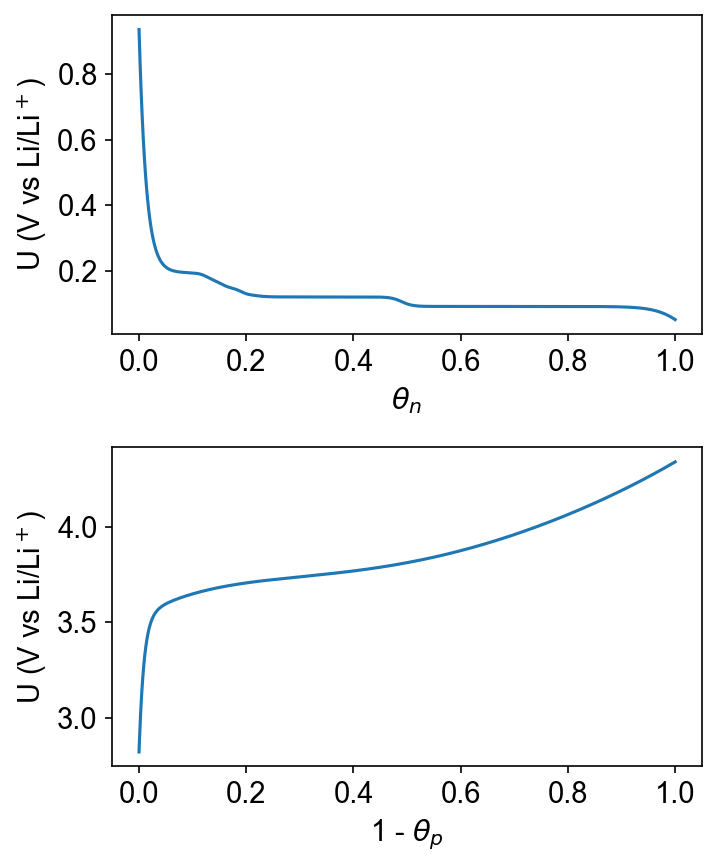

In [9]:
plt.figure(figsize=(5, 6))

theta_n = np.linspace(0, 1, 1000)
theta_p = np.linspace(0, 1, 1000)

plt.subplot(2, 1, 1)
plt.plot(theta_n, f_neg_ocv(theta_n))
plt.xlabel(r'$\theta_n$')
plt.ylabel('U (V vs Li/Li$^+$)')
plt.subplot(2, 1, 2)
plt.plot(1 - theta_p, f_pos_ocv(theta_p))
plt.xlabel(r'1 - $\theta_p$')
plt.ylabel('U (V vs Li/Li$^+$)')

## Demonstration of converting eSOH metrics to OCV

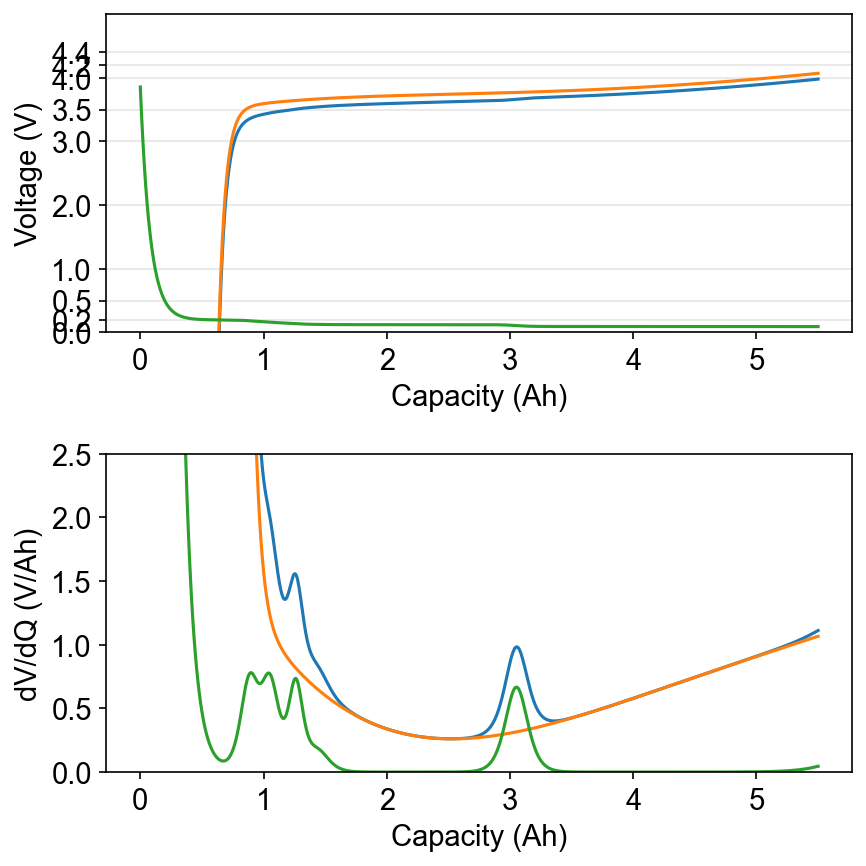

In [10]:
Cn = 5.97 # Ah
Cp = 5.97 # Ah
x100 = 0.9
y100 = 0.2

# Full cell capacity
qmax = 5.5 # Ah
q = np.linspace(0, qmax, 1000)

(Voc, Up, Un) = esoh_to_voc(x100, y100, Cn, Cp, q)

make_plot(q, Voc, Up, Un)

## Demonstration of converting degradation parameters to eSOH

x100 = [1.02955482], y100 = [0.08717356]


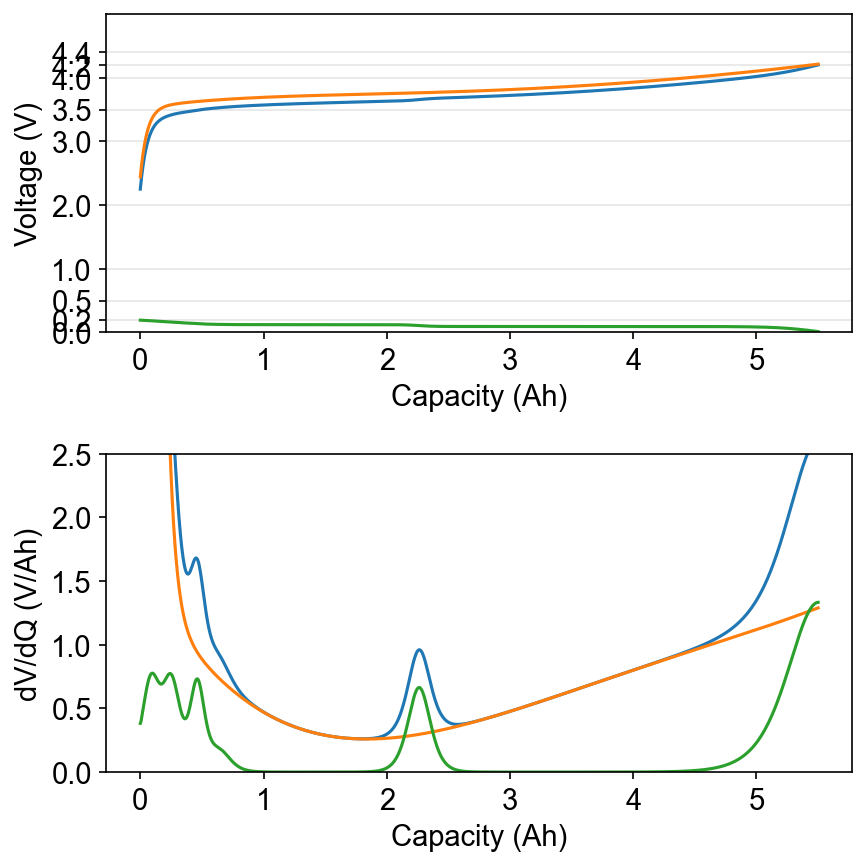

In [11]:
Cn = 6.0 # Ah
Cp = 6.0 # Ah
nlli = 0.25

Vmax = 4.2

(x100, y100) = deg_to_esoh(Cn, Cp, nlli, Vmax)

print(f'x100 = {x100}, y100 = {y100}')

(Voc, Up, Un) = esoh_to_voc(x100, y100, Cn, Cp, q)

make_plot(q, Voc, Up, Un)

## Demonstration of the graphical approach

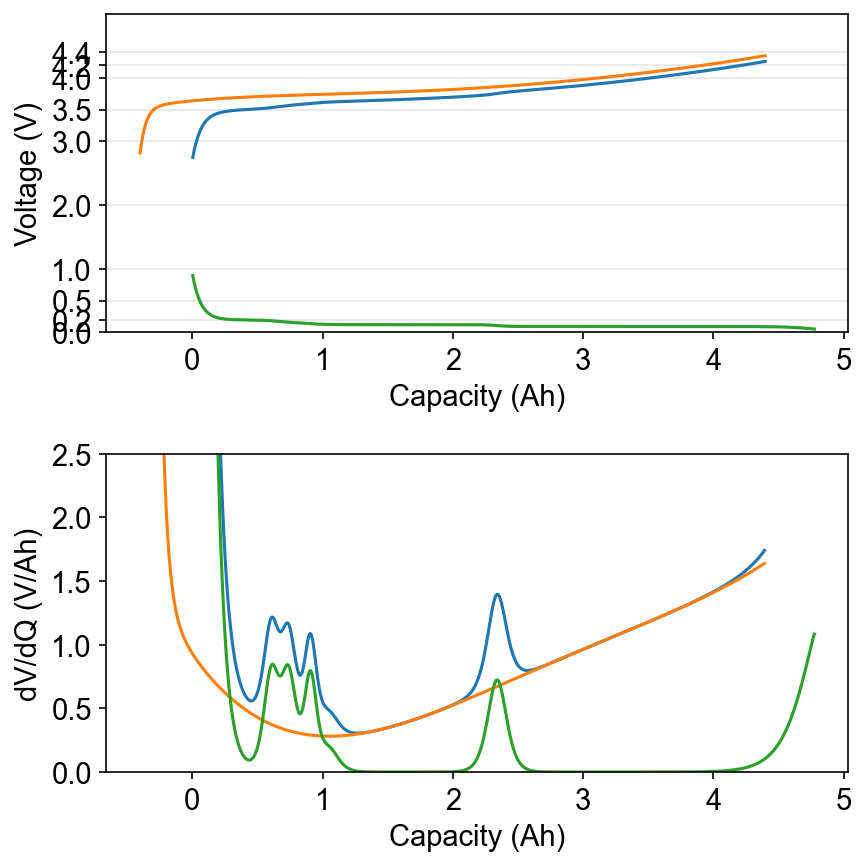

In [12]:
lli = 0.4
lam_pe = 0.2
lam_ne = 0.2
Cn = 5.97
Cp = 6.00

(Voc, Un, Up, cap) = deg_to_voc_graphical(lam_pe, lam_ne, lli, Cp, Cn)

make_plot(cap, Voc, Up, Un)